In [1]:
import nltk
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE
from textblob import TextBlob
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, accuracy_score

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/shashank2325/CMPE-255-project/main/hotelReviews.csv")
df = df.drop(columns=['Unnamed: 0'])

In [3]:
df['combined_reviews'] = df['reviews.title'].fillna('') + ' ' + df['reviews.text'].fillna('')
df.rename(columns={'combined_reviews': 'review'}, inplace=True)

#Function to clean the text for the review

In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

df['review'] = df['review'].apply(clean_text)

#Function to classify sentiment using TextBlob

In [5]:
def classify_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0.1:
        return 1  # Positive
    elif analysis.sentiment.polarity < -0.1:
        return -1  # Negative
    else:
        return 0  # Neutral

df['sentiment'] = df['review'].apply(classify_sentiment)

#Preparing the data for Modelling

In [6]:
X = df['review']
target = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)

# Vectorizing the text data
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

#Applying Naive Bayes model

In [7]:
model = MultinomialNB()

model.fit(X_train_counts, y_train)

y_pred = model.predict(X_test_counts)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.8685

Classification Report:
               precision    recall  f1-score   support

          -1       0.76      0.07      0.13       181
           0       0.44      0.49      0.46       429
           1       0.93      0.96      0.94      3390

    accuracy                           0.87      4000
   macro avg       0.71      0.51      0.51      4000
weighted avg       0.87      0.87      0.85      4000



#Analyzing the distribution of polarity scores

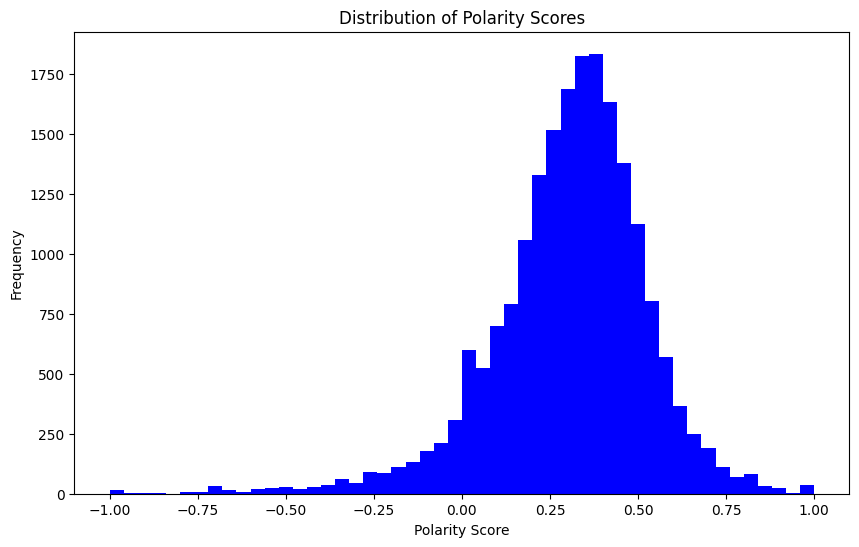

In [8]:
polarity_scores = df['review'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10, 6))
plt.hist(polarity_scores, bins=50, color='blue')
plt.title('Distribution of Polarity Scores')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.show()

# Reclassifying sentiment with new thresholds

In [ ]:
def reclassify_sentiment(text):
    analysis = TextBlob(text)
    # New thresholds for sentiment classification
    if analysis.sentiment.polarity > 0.05:
        return 1  # Positive
    elif analysis.sentiment.polarity < -0.05:
        return -1  # Negative
    else:
        return 0  # Neutral

df['sentiment'] = df['review'].apply(reclassify_sentiment)

# Reapplying the Naive Bayes model with the updated sentiment classification

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, df['sentiment'], test_size=0.2, random_state=42)

X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

model.fit(X_train_counts, y_train)

y_pred = model.predict(X_test_counts)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.90125

Classification Report:
               precision    recall  f1-score   support

          -1       0.70      0.38      0.49       230
           0       0.30      0.15      0.20       227
           1       0.93      0.98      0.95      3543

    accuracy                           0.90      4000
   macro avg       0.64      0.51      0.55      4000
weighted avg       0.88      0.90      0.88      4000



# Applying SMOTE to training data since the classes are not balanced

In [ ]:
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(df['review'])
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, df['sentiment'], test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

model.fit(X_train_smote, y_train_smote)

y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))

#Applying Logistic regression

In [12]:
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_smote, y_train_smote)

y_pred_logreg = logreg_model.predict(X_test)
print('\nLogistic Regression Model Evaluation')
print('Accuracy:', accuracy_score(y_test, y_pred_logreg))
print('\nClassification Report:\n', classification_report(y_test, y_pred_logreg))


Logistic Regression Model Evaluation
Accuracy: 0.9015

Classification Report:
               precision    recall  f1-score   support

          -1       0.61      0.64      0.63       230
           0       0.30      0.40      0.34       227
           1       0.97      0.95      0.96      3543

    accuracy                           0.90      4000
   macro avg       0.63      0.66      0.64      4000
weighted avg       0.91      0.90      0.91      4000



In [26]:
# User inputs the hotel name
user_input = input("Enter hotel name: ").lower()

Enter hotel name: The Whitney Hotel


In [27]:
# Check if the hotel is in the dataset and calculate its average sentiment
if user_input in df['name'].str.lower().values:
    target_hotel_reviews = df[df['name'].str.lower() == user_input]
    target_hotel_reviews['processed_reviews'] = target_hotel_reviews['reviews.text'].apply(preprocess_text)
    target_vectorized_reviews = vectorizer.transform(target_hotel_reviews['processed_reviews'])
    target_hotel_reviews['predicted_sentiment'] = logreg_model.predict(target_vectorized_reviews)
    average_sentiment_target = target_hotel_reviews['predicted_sentiment'].mean()
    print("Average Sentiment for", user_input, ":", average_sentiment_target)
else:
    print("Hotel not found in the dataset.")
    # Exit or continue to a different part of the program


Average Sentiment for the whitney hotel : 0.875


<ipython-input-27-151cd608c5c8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_hotel_reviews['processed_reviews'] = target_hotel_reviews['reviews.text'].apply(preprocess_text)
<ipython-input-27-151cd608c5c8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_hotel_reviews['predicted_sentiment'] = logreg_model.predict(target_vectorized_reviews)


In [36]:
# Function to preprocess text
def preprocess_text(text):
    # Add your preprocessing steps here
    return text.lower()  # Example: convert to lowercase

# User input for hotel name or city
user_input = input("Enter hotel name or city: ").lower()

# Check if the input is a hotel name
if any(df['name'].str.lower() == user_input):
    # Process for hotel name input
    hotel_name_input = user_input

    # Create a copy of the target hotel reviews to avoid SettingWithCopyWarning
    target_hotel_reviews = df[df['name'].str.lower() == hotel_name_input].copy()

    # Preprocess and vectorize reviews
    target_hotel_reviews['processed_reviews'] = target_hotel_reviews['reviews.text'].apply(preprocess_text)
    target_vectorized_reviews = vectorizer.transform(target_hotel_reviews['processed_reviews'])

    # Predict sentiments
    target_hotel_reviews['predicted_sentiment'] = logreg_model.predict(target_vectorized_reviews)

    # Calculate the average sentiment
    average_sentiment_target = target_hotel_reviews['predicted_sentiment'].mean()
    print("Average Sentiment for", hotel_name_input, ":", average_sentiment_target)

    # Assuming 'city' is a column in your DataFrame
    # Find similar hotels in the same city and create a copy
    target_city = df[df['name'].str.lower() == hotel_name_input]['city'].iloc[0]
    similar_hotels = df[df['city'] == target_city].copy()

    # Exclude the target hotel from similar hotels
    similar_hotels = similar_hotels[similar_hotels['name'].str.lower() != hotel_name_input]

    # Process and predict sentiments for similar hotels
    similar_hotels['processed_reviews'] = similar_hotels['reviews.text'].apply(preprocess_text)
    similar_hotels_vectorized = vectorizer.transform(similar_hotels['processed_reviews'])
    similar_hotels['predicted_sentiment'] = logreg_model.predict(similar_hotels_vectorized)

    # Calculate average sentiment for similar hotels
    average_sentiments_similar = similar_hotels.groupby('name')['predicted_sentiment'].mean()

    # Rank similar hotels based on average sentiment
    ranked_similar_hotels = average_sentiments_similar.sort_values(ascending=False)

    # Recommend top N similar hotels
    top_n = 5
    recommended_hotels = ranked_similar_hotels.head(top_n)
    print("Top", top_n, "recommended hotels similar to", hotel_name_input, ":")
    print(recommended_hotels)

elif any(df['city'].str.lower() == user_input):
    # Process for city input
    city_input = user_input

    # Find hotels in the entered city and create a copy to avoid SettingWithCopyWarning
    similar_hotels = df[df['city'].str.lower() == city_input].copy()

    # Process and predict sentiments for hotels in the city
    similar_hotels['processed_reviews'] = similar_hotels['reviews.text'].apply(preprocess_text)
    similar_hotels_vectorized = vectorizer.transform(similar_hotels['processed_reviews'])
    similar_hotels['predicted_sentiment'] = logreg_model.predict(similar_hotels_vectorized)

    # Calculate average sentiment for hotels in the city
    average_sentiments_city = similar_hotels.groupby('name')['predicted_sentiment'].mean()

    # Rank hotels based on average sentiment
    ranked_hotels_city = average_sentiments_city.sort_values(ascending=False)

    # Recommend top N hotels in the city
    top_n = 5
    recommended_hotels = ranked_hotels_city.head(top_n)
    print("Top", top_n, "recommended hotels in", city_input.title(), ":")
    print(recommended_hotels)

else:
    print("No matching hotels or cities found in the dataset.")


Enter hotel name or city: San Francisco
Top 5 recommended hotels in San Francisco :
name
The San Remo Hotel          1.0
The Orchard Garden Hotel    1.0
Columbus Motor Inn          1.0
The Herbert Hotel           1.0
Fitzgerald Hotel            1.0
Name: predicted_sentiment, dtype: float64


In [35]:
# Function to preprocess text
def preprocess_text(text):
    # Add your preprocessing steps here
    return text.lower()  # Example: convert to lowercase

# User input for hotel name or city
user_input = input("Enter hotel name or city: ").lower()

# Check if the input is a hotel name
if any(df['name'].str.lower() == user_input):
    # Process for hotel name input
    hotel_name_input = user_input

    # Create a copy of the target hotel reviews to avoid SettingWithCopyWarning
    target_hotel_reviews = df[df['name'].str.lower() == hotel_name_input].copy()

    # Preprocess and vectorize reviews
    target_hotel_reviews['processed_reviews'] = target_hotel_reviews['reviews.text'].apply(preprocess_text)
    target_vectorized_reviews = vectorizer.transform(target_hotel_reviews['processed_reviews'])

    # Predict sentiments
    target_hotel_reviews['predicted_sentiment'] = logreg_model.predict(target_vectorized_reviews)

    # Calculate the average sentiment
    average_sentiment_target = target_hotel_reviews['predicted_sentiment'].mean()
    print("Average Sentiment for", hotel_name_input, ":", average_sentiment_target)

    # Assuming 'city' is a column in your DataFrame
    # Find similar hotels in the same city and create a copy
    target_city = df[df['name'].str.lower() == hotel_name_input]['city'].iloc[0]
    similar_hotels = df[df['city'] == target_city].copy()

    # Exclude the target hotel from similar hotels
    similar_hotels = similar_hotels[similar_hotels['name'].str.lower() != hotel_name_input]

    # Process and predict sentiments for similar hotels
    similar_hotels['processed_reviews'] = similar_hotels['reviews.text'].apply(preprocess_text)
    similar_hotels_vectorized = vectorizer.transform(similar_hotels['processed_reviews'])
    similar_hotels['predicted_sentiment'] = logreg_model.predict(similar_hotels_vectorized)

    # Calculate average sentiment for similar hotels
    average_sentiments_similar = similar_hotels.groupby('name')['predicted_sentiment'].mean()

    # Rank similar hotels based on average sentiment
    ranked_similar_hotels = average_sentiments_similar.sort_values(ascending=False)

    # Recommend top N similar hotels
    top_n = 5
    recommended_hotels = ranked_similar_hotels.head(top_n)
    print("Top", top_n, "recommended hotels similar to", hotel_name_input, ":")
    print(recommended_hotels)

elif any(df['city'].str.lower() == user_input):
    # Process for city input
    city_input = user_input

    # Find hotels in the entered city and create a copy to avoid SettingWithCopyWarning
    similar_hotels = df[df['city'].str.lower() == city_input].copy()

    # Process and predict sentiments for hotels in the city
    similar_hotels['processed_reviews'] = similar_hotels['reviews.text'].apply(preprocess_text)
    similar_hotels_vectorized = vectorizer.transform(similar_hotels['processed_reviews'])
    similar_hotels['predicted_sentiment'] = logreg_model.predict(similar_hotels_vectorized)

    # Calculate average sentiment for hotels in the city
    average_sentiments_city = similar_hotels.groupby('name')['predicted_sentiment'].mean()

    # Rank hotels based on average sentiment
    ranked_hotels_city = average_sentiments_city.sort_values(ascending=False)

    # Recommend top N hotels in the city
    top_n = 5
    recommended_hotels = ranked_hotels_city.head(top_n)
    print("Top", top_n, "recommended hotels in", city_input.title(), ":")
    print(recommended_hotels)

else:
    print("No matching hotels or cities found in the dataset.")


Enter hotel name or city: The Whitney Hotel
Average Sentiment for the whitney hotel : 0.875
Top 5 recommended hotels similar to the whitney hotel :
name
Ace Hotel New Orleans                                 1.0
Henry Howard Hotel                                    1.0
The Roosevelt New Orleans, A Waldorf Astoria Hotel    1.0
The Pontchartrain Hotel                               1.0
The Parisian Courtyard Inn                            1.0
Name: predicted_sentiment, dtype: float64


In [37]:
import pickle

# Save the Logistic Regression model
with open('logreg_model.pkl', 'wb') as file:
    pickle.dump(logreg_model, file)

# Save the vectorizer
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)
